# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [15]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [89]:
#lets the get the dog breed data in the train, validation and test directories to different lists
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

test_path = '/data/dog_images/test/'
train_path = '/data/dog_images/train/'
valid_path = '/data/dog_images/valid/'

# Empty lists
categories = []
n_train = []
n_test = []
n_val = []

# Iterate through each category
for d in os.listdir(train_path):
    categories.append(d)
    
    train_img = os.listdir(train_path + d)
    test_img = os.listdir(test_path + d)
    val_img = os.listdir(valid_path + d)
    #append the size of each category in each dataset 
    n_train.append(len(train_img))
    n_test.append(len(test_img))
    n_val.append(len(val_img))


In [90]:
#extract only the names of the categories, replace the first four characters with just a space
categories = [item[4:].replace("_", " ") for item in categories]

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories, 'n_train': n_train, 'n_test': n_test, 'n_val': n_val}).sort_values('category')
cat_df.head()

,category,n_train,n_test,n_val
128,Affenpinscher,64,8,8
72,Afghan hound,58,8,7
63,Airedale terrier,52,6,7
92,Akita,63,8,8
20,Alaskan malamute,77,10,9


In [97]:
#lets get the statistics for each datasets
cat_df.describe()

,n_train,n_test,n_val
count,133.000000,133.000000,133.000000
mean,50.225564,6.285714,6.278195
std,11.863885,1.712571,1.350384
min,26.000000,3.000000,4.000000
25%,42.000000,5.000000,6.000000
50%,50.000000,6.000000,6.000000
75%,61.000000,8.000000,7.000000
max,77.000000,10.000000,9.000000


**The above descriptive statistics table tells us the following regarding our data:**
- The number of dog breed classes in each dataset == 133.
- The average number of samples in a specific class for the train data == 50, validation data == 6 and for the test data == 6.
- The minimum number of sample in a specific class in the training data == 26, validation data == 4, and for test data == 3.
- The maximum number of samples in a specific class in the training data == 77, validation data == 9, and for test data == 10.

Text(0.5,1,'Training Images by Category')

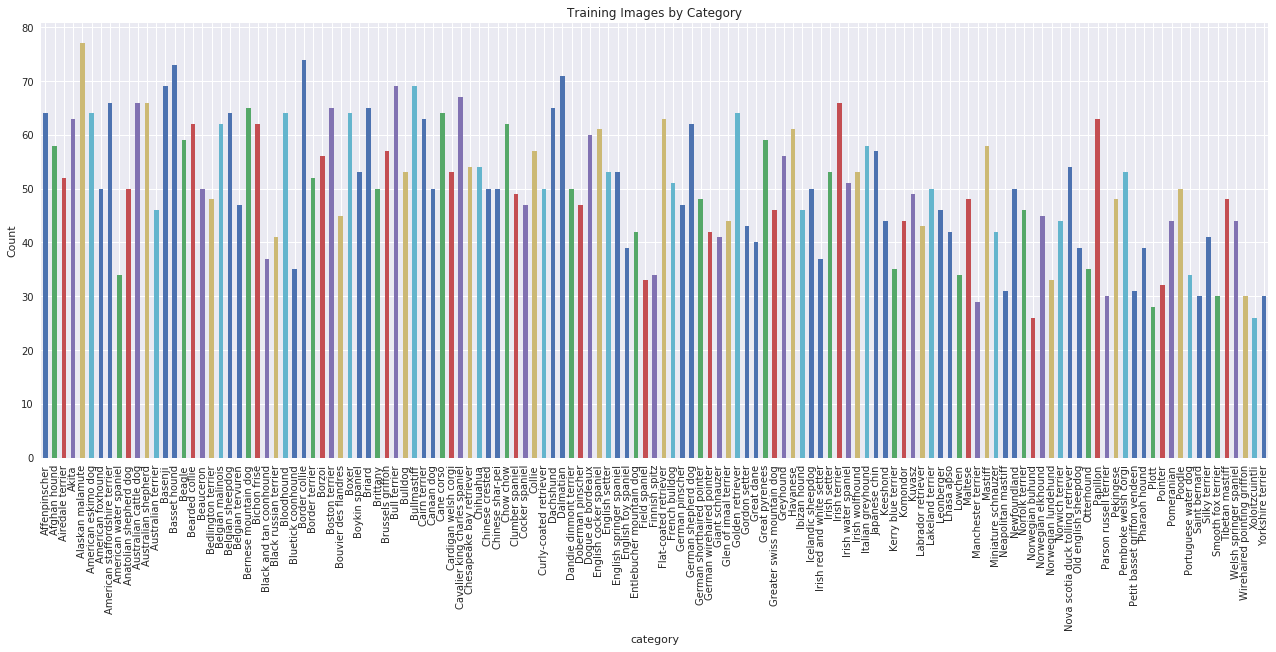

In [87]:
#typical variations in the number of different classes in the training datasets
cat_df.set_index('category')['n_train'].plot.bar( figsize=(22, 8))
plt.ylabel('Count')
plt.title('Training Images by Category')

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


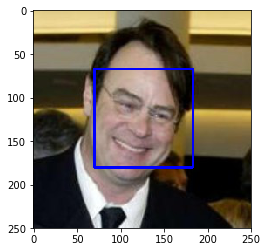

In [16]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [17]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [18]:
face_detector

<function __main__.face_detector(img_path)>

In [19]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
vfunc_face = np.vectorize(face_detector)

# Detect faces in both sets
faces_human = vfunc_face(human_files_short)
faces_dog = vfunc_face(dog_files_short)

# Calculate and print percentage of faces in each set
print(f'Faces detected in {(sum(faces_human)/len(faces_human))*100:.2f}% of the sample human dataset.')
print(f'Faces detected in {(sum(faces_dog)/len(faces_dog))*100:.2f}% of the sample dog dataset.')

Faces detected in 98.00% of the sample human dataset.
Faces detected in 17.00% of the sample dog dataset.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [20]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 84031107.69it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [21]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    img = Image.open(img_path)

    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    
    # Image transformation
    
    transform = transforms.Compose([
        transforms.Resize(224), # resize shortest side to 224 pixels
        transforms.CenterCrop(224), # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]) #recommended normalization parameters
    
    ## Return the *index* of the predicted class for that image
    img_transform = transform(img)
    
    #Pytorch treats every input tensor as a batch so we will include one dimension to out image tensor
    
    img_load = img_transform.view(1, 3, 224, 224) # 1 - One batch, 3 - 3 color channels, 224 - 224 width, 224 - 224 - height
    
    # Turn the input into a Variable
    if use_cuda:
        img_variable = Variable(img_load.cuda())
        
    VGG16.eval()
    # Predict the class of the image
    with torch.no_grad():
        output = VGG16(img_variable)
        output = output.cpu()
        pred_index = output.numpy().argmax()

    
    return pred_index # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [26]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    img_class = VGG16_predict(img_path)
    if((img_class > 150) & (img_class < 269)):
        return True
    else: 
        return False
    
print('Is dog detected in human files? --', dog_detector(human_files[0]))
print('Is dog detected in dog files? --', dog_detector(dog_files[0]))

Is dog detected in human files? -- False
Is dog detected in dog files? -- True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

***Answer:*** **Pecentage of the dog images detected in human files is 0.0%.**
                
 **Pecentage of the dog images detected in dog files is 100.0%.**


In [27]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

vfunc_dog = np.vectorize(dog_detector)

# Detect dog in human & dogshort datasets
detect_dog_human = vfunc_dog(human_files_short)
detect_dog = vfunc_dog(dog_files_short)

# Calculate and print percentage of faces in each set
print(f'Pecentage of the dog images detected in human files is {detect_dog_human.mean()*100}%')
print(f'Pecentage of the dog images detected in dog files is {detect_dog.mean()*100}%')


Pecentage of the dog images detected in human files is 0.0%
Pecentage of the dog images detected in dog files is 100.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [28]:
# Image transformations based on recommended normalization parameters
#Data Augmentation

train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(256),             # resize shortest side to 256 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])


# Test and validation dataset do not require augmentation

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [29]:
import os
from torchvision import datasets
from torchvision import datasets,transforms, models
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

root = '/data/dog_images/'
batch_size = 20

#loading datasets
train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform = train_transform)
val_data = datasets.ImageFolder(os.path.join(root, 'valid'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform = test_transform)

# Loading batches
loaders_scratch = {
    'train' : torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle=True),
    'valid' : torch.utils.data.DataLoader(val_data,batch_size = batch_size),
    'test' : torch.utils.data.DataLoader(test_data,batch_size = batch_size)    
}

class_names = train_data.classes


In [30]:
#the class names in numeric order
print('The dog breeds in numeric order:')
[names for names in class_names]

The dog breeds in numeric order:


['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois',
 '021.Belgian_sheepdog',
 '022.Belgian_tervuren',
 '023.Bernese_mountain_dog',
 '024.Bichon_frise',
 '025.Black_and_tan_coonhound',
 '026.Black_russian_terrier',
 '027.Bloodhound',
 '028.Bluetick_coonhound',
 '029.Border_collie',
 '030.Border_terrier',
 '031.Borzoi',
 '032.Boston_terrier',
 '033.Bouvier_des_flandres',
 '034.Boxer',
 '035.Boykin_spaniel',
 '036.Briard',
 '037.Brittany',
 '038.Brussels_griffon',
 '039.Bull_terrier',
 '040.Bulldog',
 '041.Bullmastiff',
 '042.Cairn_terrier',
 '043.Canaan_do

In [31]:
class_names[0]

'001.Affenpinscher'

In [32]:
print(f'Training images available: {len(train_data)}')
print(f'Validation images available: {len(val_data)}')
print(f'Testing images available: {len(test_data)}')

Training images available: 6680
Validation images available: 835
Testing images available: 836


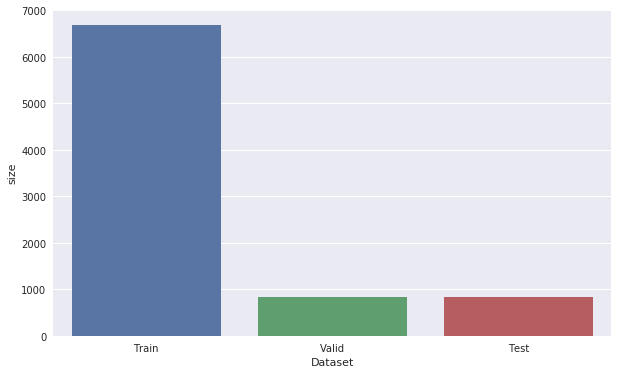

In [33]:
data_size = [['Train',len(train_data)],['Valid',len(val_data)],['Test',len(test_data)]]
df_data = pd.DataFrame(data_size,columns=['Dataset','size'])

plt.figure(figsize = (10,6))
sns.set(style="darkgrid")
sns.barplot(x="Dataset", y="size", data=df_data)

### Lets display the first batch of Dog images

***lets see how they look like :(***

Label: [ 61  63  11  13   2  67  89  19   2  15  69  82  82   4  43  39  21 103
  90  45]
Class: 062.English_setter 064.English_toy_spaniel 012.Australian_shepherd 014.Basenji 003.Airedale_terrier 068.Flat-coated_retriever 090.Italian_greyhound 020.Belgian_malinois 003.Airedale_terrier 016.Beagle 070.German_pinscher 083.Ibizan_hound 083.Ibizan_hound 005.Alaskan_malamute 044.Cane_corso 040.Bulldog 022.Belgian_tervuren 104.Miniature_schnauzer 091.Japanese_chin 046.Cavalier_king_charles_spaniel


(-0.5, 1131.5, 905.5, -0.5)

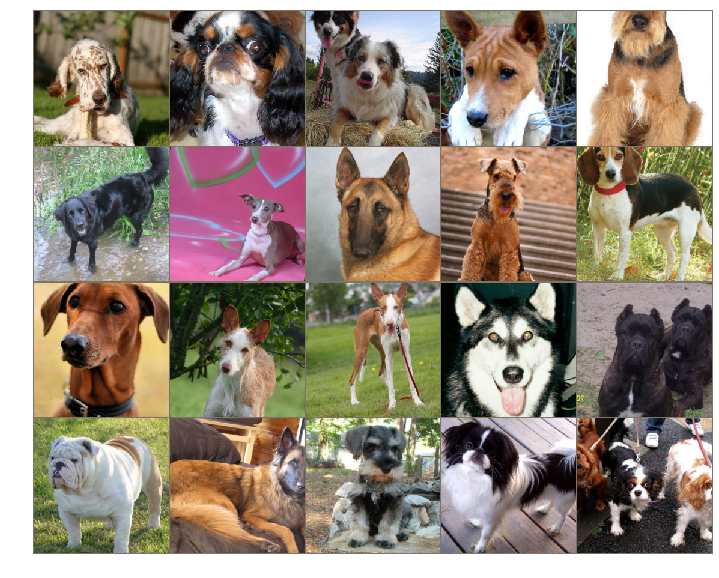

In [34]:
from torchvision.utils import make_grid

# Grab the first batch of 20 images
for images,labels in loaders_scratch['train']: 
    break
    
# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the means 5 images per row

# Inverse normalize the images
#We inversely normalize the images so that we can visualize the actual image

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(16,10))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: - I resized the images using the ``transforms operations in pytorch`` and this includes:
- ``transforms.Resize(256)`` this resizes the smallest edge of the images to a 256 size which is much needed before we centre crop.
- ``transforms.Centrecrop(224 x 224)`` this scales down all the images to 224 x 224 (height x width) which is required when preparing our images for the CNN. It is also needed before we perform transfer learning because the deep CNN that were used for the Imagenet data requires all image tensors to have a 224 x 224 size.

- I decided to augment the dataset because this artifically increase the number of training images our model sees through the use of these random transformations: ``transforms.RandomHorizontalFlip(p=0.5)`` - horizontally flip the given PIL image randomly with a given probability and ``transforms.RandomRotation(10)`` - randomly rotates the PIL images between +10 and -10 degrees. 
- The main idea behind Data augmentation is to help reduce overfittng this is because as our network is exposed different variations/distortions of the input image tensors it helps improve its performance in understanding the underlying patterns of the images which further helps in better generalization to out-of-sample test data.

- It is IMPORTANT to note that data augmentation is only done during training!...this is because you dont want to add noise or distort your test / real world sample image(s).

- I also performed normalization on the input image ``transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`` this serves to make convergence happen quicker during training based on various research in CNN.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [35]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.steps = nn.Sequential(
        nn.Conv2d(3, 16, 3, 1),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.MaxPool2d(2,2, ceil_mode = True),
        
        nn.Conv2d(16,32,3,1),
        nn.BatchNorm2d(32),
        nn.ReLU(True),
        nn.MaxPool2d(2,2, ceil_mode = True),
        
        nn.Conv2d(32,64,3,1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.MaxPool2d(2,2, ceil_mode = True),
        
        nn.Conv2d(64,128,3,1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.MaxPool2d(2,2, ceil_mode = True),
        
        nn.Conv2d(128,256,3,1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.MaxPool2d(2,2, ceil_mode = True))
        
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(256*6*6, 133)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.steps(x)
        x = x.view(-1, 256*6*6)
        x = self.dropout(x)
        x = self.fc1(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [36]:
#lets take a look at the parameters for this model
model_scratch

Net(
  (steps): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2

In [37]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item}')
    print(f'________\n{sum(params)}')

In [38]:
#Lets calculate the total sum of parameters for our model

count_parameters(model_scratch)

432
16
16
16
4608
32
32
32
18432
64
64
64
73728
128
128
128
294912
256
256
256
1225728
133
________
1619461


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

- **First**, Five (5) convolutional layers were selected for the CNN architecture based on previous literatures on dog breed classification challenges, the structure includes:


- Conv_layer1: input_channels(3), output_channels(16)
- Conv_layer2: input_channels(16), output_channels(32)
- Conv_layer3: input_channels(32), output_channels(64)
- Conv_layer4: input_channels(64), output_channels(128)
- Conv_layer5: input_channels(128), output_channels(256)


- **Note that**: Input image tensors: 224 x 224 (each in 3 RGB color channels); filter size for the whole CNN architecture (3 x 3), stride = 1, Padding = 0 (i.e. No zero padding was done)


- **Second**, After every convolutional layer, Batch Normalization was done to normalize the input layers to have a mean == 0 and variance == 1. This is done in cognizance with the research paper on Batch Normalization  [Batch Normalization: Accelerating Deep Network Training by
Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf).


- **Third**, After the batch normalization, Activation function called Relu max(0,x) (- Rectificied linear unit) was used to activate the normalized neurons, which basically converts incoming inputs less than 0 to 0 and those higher to their exact number.


- **Fourth**, After performing non-linearity on the normalized neuron, Maxpooling layer (2,2) was used to downsample the number of neurons in each feature maps(i.e. taking the maximum weighted value within a 2 by 2 block). This means if the incoming (activated and normalized) convolutional layer has 16 feature maps/channels/depths, max pooling layer is applied to each and every one of them.


- **Fifth**, After the fifth (and final) Max pooling, Dropout(0.2) is applied to the pooling layer, to further reduce overfitting by randomly (and temporarily) deleting about 20% of the neurons in the layer.


- **Finally**, We pass the input neurons (in which 20% of it has been dropped out) to a Fully connected (FC) layer(256x6x6) and then this FC layer ouputs the 133 intended classes of the dog breeds.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [67]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [68]:
#allow pil images of varying sizes to be opened

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [69]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            #forward pass
            y_pred = model(data)
            
            ## find the loss and update the model parameters accordingly
            loss = criterion(y_pred, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform the optimization step for the purpose of gradient descent(parameter update)
            optimizer.step()
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            y_val = model(data)
            
            # find the validation loss
            loss = criterion(y_val, target)
            
            ## update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
     
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f'The best validation loss is presently: {valid_loss:.6f}. Saving model...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
model_scratch = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.000425 	Validation Loss: 0.004502
The best validation loss is presently: 0.004502. Saving model...
Epoch: 2 	Training Loss: 0.000414 	Validation Loss: 0.004491
The best validation loss is presently: 0.004491. Saving model...
Epoch: 3 	Training Loss: 0.000408 	Validation Loss: 0.004501
Epoch: 4 	Training Loss: 0.000403 	Validation Loss: 0.004395
The best validation loss is presently: 0.004395. Saving model...
Epoch: 5 	Training Loss: 0.000400 	Validation Loss: 0.004481
Epoch: 6 	Training Loss: 0.000396 	Validation Loss: 0.004419
Epoch: 7 	Training Loss: 0.000392 	Validation Loss: 0.004533
Epoch: 8 	Training Loss: 0.000382 	Validation Loss: 0.004428
Epoch: 9 	Training Loss: 0.000382 	Validation Loss: 0.004412
Epoch: 10 	Training Loss: 0.000374 	Validation Loss: 0.004451


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [70]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.558323


Test Accuracy: 21% (176/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [62]:
## TODO: Specify data loaders

# Image transformations based on recommended normalization parameters
#Data Augmentation
#THE ONLY CHANGE HERE IS THE RESIZE PIXEL == 224

train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])


# Test and validation dataset do not require augmentation

valid_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


root = '/data/dog_images/'
batch_size = 20

#loading datasets
train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform = train_transform)
val_data = datasets.ImageFolder(os.path.join(root, 'valid'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform = test_transform)

# Loading batches
loaders_transfer = {
    'train' : torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle=True),
    'valid' : torch.utils.data.DataLoader(val_data,batch_size = batch_size),
    'test' : torch.utils.data.DataLoader(test_data,batch_size = batch_size)    
}

## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 133.

In [44]:
## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)
model_transfer

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 41186081.65it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [45]:
import torchvision.models as models
import torch.nn as nn

## TODO: Freeze resnet50 parameters 
for param in model_transfer.parameters():
    param.requires_grad = False

#parameters to fine-tune
model_transfer.fc = nn.Linear(in_features=2048, out_features=133, bias=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
    print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [46]:
# Calculate the total number of parameters we want to train
count_parameters(model_transfer)

272384
133
________
272517


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

**I used ResNet 50 as my pretrained model, This model has 50 parameter layers thats was optimized and utilized for the Imagenet classification achieving 6.71% top-5 error rate in 2015  [Resnet research paper -- He et al., 2015](https://arxiv.org/pdf/1512.03385.pdf). The logic behind the ResNet CNN structure is that it performs residual learning to each of the stacked layers in its DNN architecture by using shortcut connections to perform identity mapping to these individual layers ( - where the identity (x) that is to be learnt by a layer is recast into it after the layer has been activated i.e F(x) + x, this basically is residual mapping where each layer is directly fitted to a desired underlying pattern / identity).**

**I basically used this model because it worked pretty well for this specific problem yielding 87% accuracy and 0.86 test loss, and it was faster to train than the other networks with larger layers making it computationally efficient for this project.**

- The architecture of the ResNet 50 consist of Convolutional layer, Batch normalization layer, Relu activation function layer, Average pooling layer and finally a Fully connected layer all of which are arranged based on the discretion of the network creators and developers.

- For the purpose of transfer learnng, All the layers **prior** to the last fully connected (FC) layer in the network were **FROZEN i.e. we didn't train them.**

- We replayed the last fully connected layer output with 133 output neurons leaving its input neurons as 2048.

- This means that we are going to train only about 272,000 weights and 133 biases of the last FC layer for this transfer learning model.

**Overall, I believe that ResNet 50 is well suited for this dog classification problem because it was successfully able to transfer its knowledge from the ImageNet classification challenge to our small dog breed classification project, which is basically the principal aim of transfer learning.**



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [71]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr = 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [72]:
# train the model
n_epochs = 10
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

#load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000122 	Validation Loss: 0.001329
The best validation loss is presently: 0.001329. Saving model...
Epoch: 2 	Training Loss: 0.000083 	Validation Loss: 0.001126
The best validation loss is presently: 0.001126. Saving model...
Epoch: 3 	Training Loss: 0.000071 	Validation Loss: 0.001207
Epoch: 4 	Training Loss: 0.000058 	Validation Loss: 0.001074
The best validation loss is presently: 0.001074. Saving model...
Epoch: 5 	Training Loss: 0.000050 	Validation Loss: 0.001142
Epoch: 6 	Training Loss: 0.000051 	Validation Loss: 0.000882
The best validation loss is presently: 0.000882. Saving model...
Epoch: 7 	Training Loss: 0.000045 	Validation Loss: 0.001030
Epoch: 8 	Training Loss: 0.000042 	Validation Loss: 0.001017
Epoch: 9 	Training Loss: 0.000041 	Validation Loss: 0.001069
Epoch: 10 	Training Loss: 0.000036 	Validation Loss: 0.001006


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [73]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.865726


Test Accuracy: 87% (731/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [74]:
class_name = [item[4:].replace("_", " ") for item in train_data.classes]
print(class_name)

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog', 'Australian cattle dog', 'Australian shepherd', 'Australian terrier', 'Basenji', 'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron', 'Bedlington terrier', 'Belgian malinois', 'Belgian sheepdog', 'Belgian tervuren', 'Bernese mountain dog', 'Bichon frise', 'Black and tan coonhound', 'Black russian terrier', 'Bloodhound', 'Bluetick coonhound', 'Border collie', 'Border terrier', 'Borzoi', 'Boston terrier', 'Bouvier des flandres', 'Boxer', 'Boykin spaniel', 'Briard', 'Brittany', 'Brussels griffon', 'Bull terrier', 'Bulldog', 'Bullmastiff', 'Cairn terrier', 'Canaan dog', 'Cane corso', 'Cardigan welsh corgi', 'Cavalier king charles spaniel', 'Chesapeake bay retriever', 'Chihuahua', 'Chinese crested', 'Chinese shar-pei', 'Chow chow', 'Clumber spaniel', 'Cocker spaniel', 'Collie',

In [75]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_name = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    
    # load the image and return the predicted breed
    img = Image.open(img_path)
    
    transform = transforms.Compose([
        transforms.Resize(224), # resize shortest side to 224 pixels
        transforms.CenterCrop(224), # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]) #recommended normalization parameters
    
    ## Return the *index* of the predicted class for that image
    img_transform = transform(img)
    
    #Pytorch treats every input tensor as a batch so we will include one dimension to out image tensor
    
    img_load = img_transform.view(1, 3, 224, 224) # 1 - One image per batch, 3 - 3 color channels, 224 - 224 width, 224 - 224 - height
    
    # Turn the input into a Variable
    if use_cuda:
        img_variable = Variable(img_load.cuda())
        
    model_transfer.eval()
    # Predict the class of the image
    with torch.no_grad():
        output = model_transfer(img_variable)
        output = output.cpu()
        pred_index = output.numpy().argmax()

    
    return class_name[pred_index] # predicted class index

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [80]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.



def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    plt.axis('off')
    
    if(face_detector(img_path)):
        print('A human being is detected')
    elif(dog_detector(img_path)):
        pred_dog = predict_breed_transfer(img_path)
        print(f'A specific dog breed is detected called:{pred_dog}')
    else:
        print('Neither a human being nor a dog is detected')


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
- More training dataset will be required to improve the algorithm and reduce overfitting, this is because DNN are data hungry -- Increased training data improves their generalization to unseen data.
- State-of-art models with deeper layers could be further utilized to improve our model performance, as it is shown in various research papers that deeper networks yield top error rates in image classification challenges.
- In addition to our model built from scratch (which serve as our baseline model), other benchmark models could be develop to compare and contrast how different models (based on their architectures and parameters) generalize to out-of-sample images.

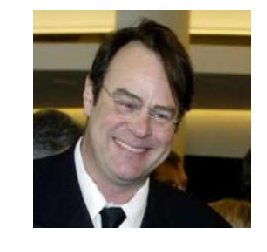

A human being is detected


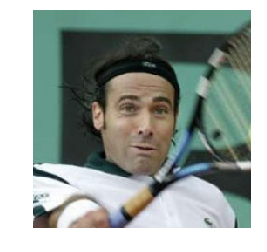

A human being is detected


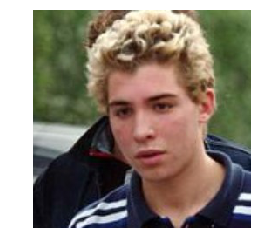

A human being is detected


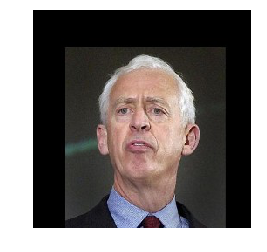

A human being is detected


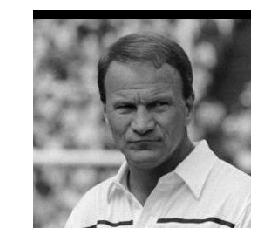

A human being is detected


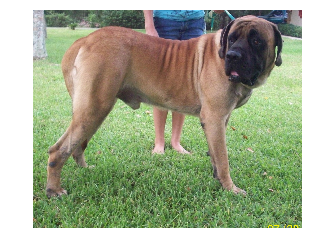

A specific dog breed is detected called:Mastiff


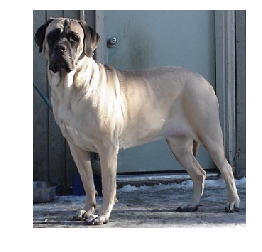

A specific dog breed is detected called:Bullmastiff


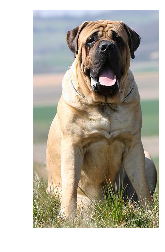

A specific dog breed is detected called:Bullmastiff


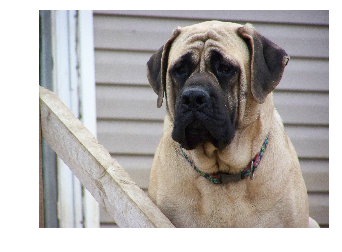

A specific dog breed is detected called:Mastiff


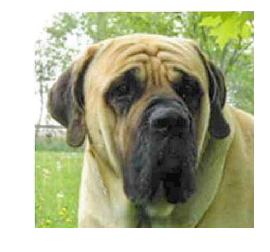

A specific dog breed is detected called:Bullmastiff


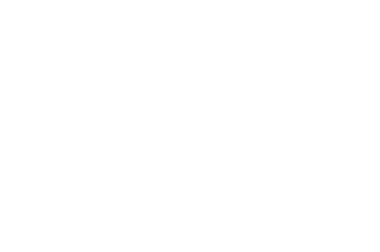

In [81]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
plt.axis('off')
for file in np.hstack((human_files[:5], dog_files[:5])):
    run_app(file)